In [62]:
import importlib
import tensorflow as tf
from tensorflow import keras
import yaml
import os
import numpy as np
import json
import matplotlib.pyplot as plt

import dataset
import utils
importlib.reload(dataset)
importlib.reload(utils)
from dataset import *
import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf



In [63]:
config_name = "wallerlab_reconstruction"
model_path = '/home/jreymond/lensless_ml/stored_models/2023-04-17/wallerlab_unet.pb'

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="configs", job_name="test_app")
config = compose(config_name= config_name)

/tmp/ipykernel_1204558/1477390475.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs", job_name="test_app")


In [64]:
num_samples = 3

print(config['dataset']['len'])
dataset_generator = WallerlabGenerator(config['dataset'],  
                                       indexes=np.arange(config['dataset']['len']), 
                                       batch_size=config['batch_size'],
                                       greyscale=config['greyscale'], 
                                       seed=config['seed'])

X, Y = dataset_generator.get_random_samples(num_samples)


7513


In [65]:

model = tf.saved_model.load(model_path)

In [66]:
Y_gen = model(tf.convert_to_tensor(X))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


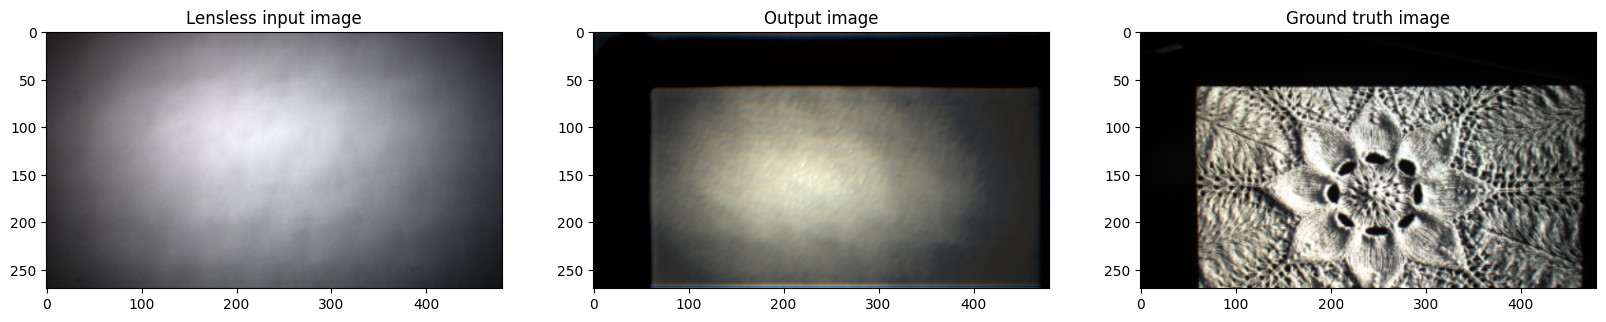

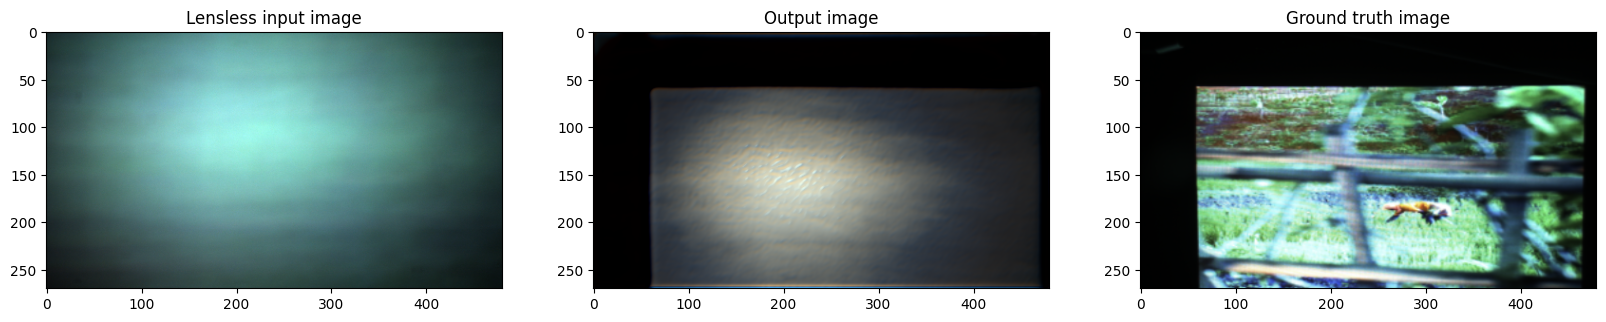

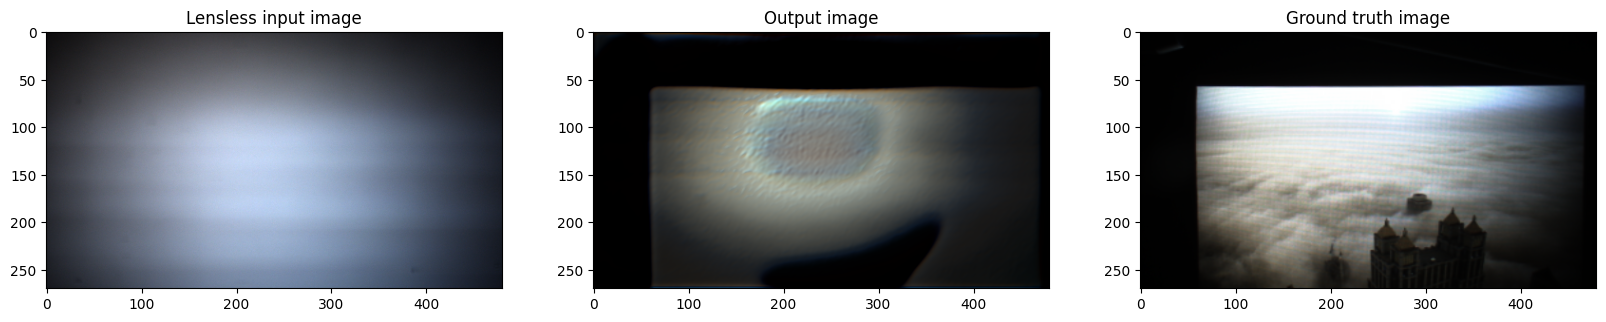

In [68]:
for i in range(num_samples):
    measurement = dataset_generator.to_plottable_measurement(X[i])
    output = dataset_generator.to_plottable_output(Y_gen[i].numpy())
    ground_truth = dataset_generator.to_plottable_output(Y[i])

    fig1, ax = plt.subplots(1, 3, figsize=(20,5))
    ax[0].imshow(measurement)
    ax[0].set_title('Lensless input image')

    ax[1].imshow(output)
    ax[1].set_title('Output image')

    ax[2].imshow(ground_truth)
    ax[2].set_title('Ground truth image');
